First, we build the Integers.

In [1]:
from dataclasses import dataclass
from typing import List

In [2]:
# we start with the holy binary NAND gate (::bow::) (sorry NOR)
# NAND is Universal, i.e. we can build any boolean expression out of it alone. Cool right?

# bnand = lambda a, b: 0 if a == 1 and b == 1 else 1

# nvm let's wrap values into classes so we can trace the graph and create pretty visualizations

class Node:
    
    def __init__(self, bit, prev=None):
        self.bit = bit
        self._prev = [] if prev is None else prev
    
    def __repr__(self):
        return "Node(%d)" % self.bit

def bnand(a, b):
    
    # wrap inputs into Nodes if needed
    if isinstance(a, int):
        a = Node(a)
    if isinstance(b, int):
        b = Node(b)

    # calculate nand
    out_bit = 0 if a.bit == 1 and b.bit == 1 else 1
    out = Node(out_bit, [a, b]) # keep pointers to the children of this node
    
    return out

print(0, 0, bnand(0, 0))
print(0, 1, bnand(0, 1))
print(1, 0, bnand(1, 0))
print(1, 1, bnand(1, 1))

0 0 Node(1)
0 1 Node(1)
1 0 Node(1)
1 1 Node(0)


In [3]:
# binary not
bnot = lambda a: bnand(a, a)
print(0, bnot(0))
print(1, bnot(1))

0 Node(1)
1 Node(0)


In [4]:
# binary and
band = lambda a, b: bnot(bnand(a, b))
print(0, 0, band(0, 0))
print(0, 1, band(0, 1))
print(1, 0, band(1, 0))
print(1, 1, band(1, 1))

0 0 Node(0)
0 1 Node(0)
1 0 Node(0)
1 1 Node(1)


In [5]:
# binary xor
bxor = lambda a, b: band(bnand(a, b), bnand(bnot(a), bnot(b)))
print(0, 0, bxor(0, 0))
print(0, 1, bxor(0, 1))
print(1, 0, bxor(1, 0))
print(1, 1, bxor(1, 1))

0 0 Node(0)
0 1 Node(1)
1 0 Node(1)
1 1 Node(0)


In [6]:
# binary or
bor = lambda a, b: bnot(band(bnot(a), bnot(b)))
print(0, 0, bor(0, 0))
print(0, 1, bor(0, 1))
print(1, 0, bor(1, 0))
print(1, 1, bor(1, 1))

0 0 Node(0)
0 1 Node(1)
1 0 Node(1)
1 1 Node(1)


In [7]:
def half_adder(a, b):
    s = bxor(a, b) # sum
    c = band(a, b) # carry
    return s, c

print(0, 0, half_adder(0, 0))
print(0, 1, half_adder(0, 1))
print(1, 0, half_adder(1, 0))
print(1, 1, half_adder(1, 1))

0 0 (Node(0), Node(0))
0 1 (Node(1), Node(0))
1 0 (Node(1), Node(0))
1 1 (Node(0), Node(1))


In [8]:
def full_adder(a, b, c): # adds 3 bits by connecting two half_adders in series
    s1, c1 = half_adder(a,  b)
    s2, c2 = half_adder(s1, c)
    return s2, bor(c1, c2)

print(0, 0, 0, full_adder(0, 0, 0))
print(0, 0, 1, full_adder(0, 0, 1))
print(0, 1, 0, full_adder(0, 1, 0))
print(0, 1, 1, full_adder(0, 1, 1))
print(1, 0, 0, full_adder(1, 0, 0))
print(1, 0, 1, full_adder(1, 0, 1))
print(1, 1, 0, full_adder(1, 1, 0))
print(1, 1, 1, full_adder(1, 1, 1))

0 0 0 (Node(0), Node(0))
0 0 1 (Node(1), Node(0))
0 1 0 (Node(1), Node(0))
0 1 1 (Node(0), Node(1))
1 0 0 (Node(1), Node(0))
1 0 1 (Node(0), Node(1))
1 1 0 (Node(0), Node(1))
1 1 1 (Node(1), Node(1))


In [9]:

@dataclass
class UInt:
    bits: List[Node]
    
    def val(self):
        # return the python object of the stored integer
        u = sum((2**i if d.bit==1 else 0) for i,d in enumerate(self.bits[::-1]))
        return u
    
    def __add__(self, other):
        assert len(self.bits) == len(other.bits)
        
        out = []
        c = 0
        for a, b in zip(self.bits[::-1], other.bits[::-1]):
            s, c = full_adder(a, b, c)
            out.append(s)
        
        # note: final carry gets dropped! such is life in a finite universe
        return UInt(out[::-1])


In [10]:
def uint_binary(num, nbits=8):
    assert 0 <= num < 2**nbits
    out = []
    for _ in range(nbits):
        bit = num %  2
        num = num // 2
        out.append(bit)
    return out[::-1]

uint_binary(6, nbits=8)

[0, 0, 0, 0, 0, 1, 1, 0]

In [64]:
# ok les do verification
nbits = 4 # test addition of up to 4-bit integers, so range 0..15
nrang = 2**nbits
ntests = 0
for a in range(nrang):
    for b in range(nrang):
        a_bits = list(map(Node, uint_binary(a, nbits=nbits)))
        b_bits = list(map(Node, uint_binary(b, nbits=nbits)))
        s = UInt(a_bits) + UInt(b_bits)
        assert ((a + b) % nrang) == s.val()
        ntests += 1
print(ntests, 'OK')

256 OK


In [78]:
# make up some random addition example
a_bits = list(map(Node, uint_binary(103, nbits=8)))
b_bits = list(map(Node, uint_binary(79, nbits=8)))
s = UInt(a_bits) + UInt(b_bits)

In [79]:
a_bits

[Node(0), Node(1), Node(1), Node(0), Node(0), Node(1), Node(1), Node(1)]

In [80]:
b_bits

[Node(0), Node(1), Node(0), Node(0), Node(1), Node(1), Node(1), Node(1)]

In [81]:
s.bits

[Node(1), Node(0), Node(1), Node(1), Node(0), Node(1), Node(1), Node(0)]

In [82]:
s.val()

182

In [84]:
103 + 79

182

In [85]:
from graphviz import Digraph

In [90]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    
    nodes, edges = set(), set()
    for r in root.bits:
        ns, es = trace(r)
        nodes.update(ns)
        edges.update(es)
    
    print(len(nodes))
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        
        if n._prev:
            label = "{ %d NAND %d = %d }" % (n._prev[0].bit, n._prev[1].bit, n.bit)
        else:
            label = "{ %d }" % (n.bit, )
            
        dot.node(name=str(id(n)), label=label, shape='record')
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))
    
    return dot

179


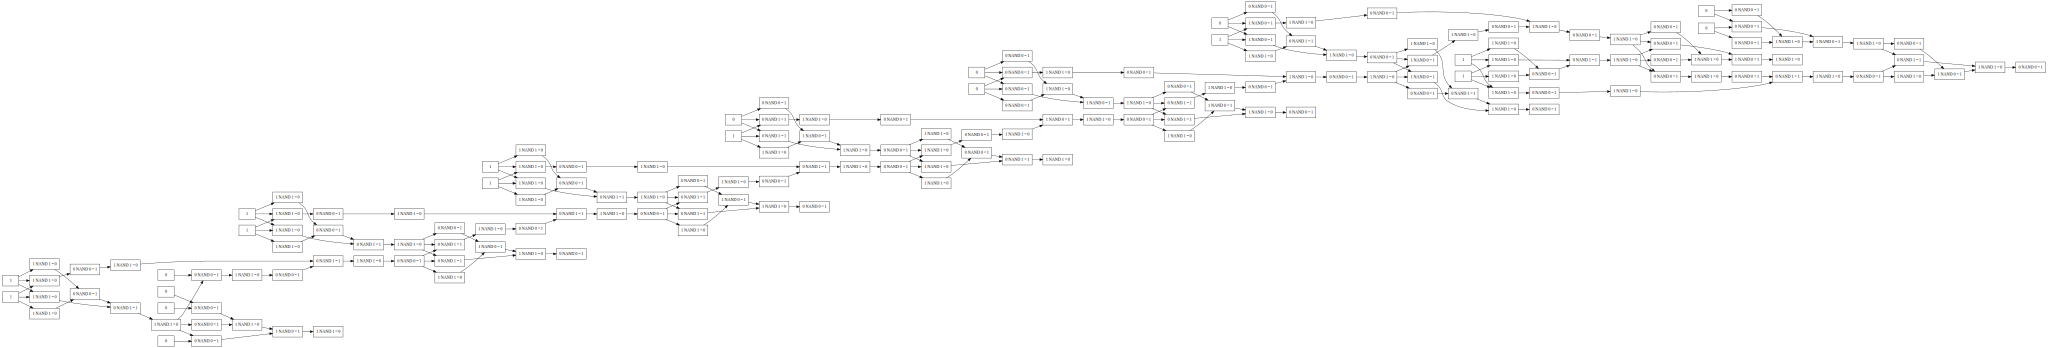

In [91]:
dot = draw_dot(s, rankdir='LR')
dot

In [88]:
dot.render('gout')

'gout.svg'

In [89]:
dot.render('gout', format='jpg')

'gout.jpg'